In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
from PIL import Image
import random
from tqdm import tqdm

d:\Conda\envs\NLP\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Nie można odnaleźć określonej procedury'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
IMG_DIMS = (256, 256)
BATCH_SIZE = 16
LEARNING_RATES = [0.01, 0.001, 0.0001]

# Dataset info
DEFOCUSED_BLURRED = "defocused_blurred"
SHARP = "sharp"

In [3]:
defocused_blurred_images_paths = [f"{DEFOCUSED_BLURRED}/{path}" for path in os.listdir(DEFOCUSED_BLURRED)]
sharp_images_paths = [f"{SHARP}/{path}" for path in os.listdir(SHARP)]

In [4]:
files_paths_packed = []
for defocused, sharp in zip(defocused_blurred_images_paths, sharp_images_paths):
    files_paths_packed.append([defocused, sharp])

In [5]:
class DefoccusedAndMotionBluredDataset(Dataset):
    def __init__(self, data, transforms) -> None:
        super().__init__()
        self.ln = len(data)
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return self.ln
        
    def __getitem__(self, index):
        defocused, sharp = self.data[index]
        
        defocused = Image.open(defocused)
        sharp = Image.open(sharp)
        
        return self.transforms(defocused), self.transforms(sharp)

In [6]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMG_DIMS),
    torchvision.transforms.ToTensor(),
])

In [7]:
ds = DefoccusedAndMotionBluredDataset(files_paths_packed, transforms)
dataloader = DataLoader(ds, BATCH_SIZE, True)

In [8]:
class DeblurrerModel(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            nn.AvgPool2d(2),
            
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            nn.AvgPool2d(2),
            
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            nn.AvgPool2d(2),
            
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            nn.AvgPool2d(2),
            
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            nn.AvgPool2d(2),
        )

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(channels, channels, 4, 2, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(channels, channels, 4, 2, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(channels, channels, 4, 2, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(channels, channels, 4, 2, 1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(channels, 3, 4, 2, 1),
        )
        
    def forward(self, x):
        
        out = self.encoder(x)
        out = self.decoder(out)

        return out

In [9]:
class Deblurrer:
    def __init__(self, dataloader: DataLoader, channels: int = 128, epochs: int = 100, learning_rates: list[int] = LEARNING_RATES):
        self.dataloader = dataloader
        
        self.model = DeblurrerModel(channels)
        self.optimizer = Adam(self.model.parameters())
        
        self.epochs = epochs
        
        self.criterion = nn.MSELoss()
        
        self.device = ("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on:", self.device)
        
        self.model.to(self.device)
    
    def train(self):
        for epoch in range(self.epochs):
            for x, y in tqdm(self.dataloader):
                x = x.to(self.device)
                y = y.to(self.device)
                
                self.optimizer.zero_grad()
                self.model.train()
                
                out = self.model(x)
                loss = self.criterion(out, y)

                
                loss.backward()
                self.optimizer.step()
            
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {loss.item()}")
            self.sample()
    
    def sample(self):
        ln = len(self.dataloader.dataset)
        random_index = random.randint(0, ln - 1)
        x, y = self.dataloader.dataset[random_index]
        
        columns = 1
        rows = 3
        
        titles = ["Focus Blur", "Focus Blur After Model", "Sharp"]
        
        self.model.eval()
        with torch.no_grad():
            deblurred = self.model(x.unsqueeze(0).to(self.device))
        
        if deblurred.dim() == 4:
            deblurred = deblurred.squeeze(0)
        
        deblurred = deblurred.detach().cpu().permute(1, 2, 0).numpy()
        x = x.permute(1, 2, 0).numpy()
        y = y.permute(1, 2, 0).numpy()
        
        fig = plt.figure(figsize=(15, 15))
        cnt = 0
        for i in range(1, 4):
            fig.add_subplot(columns, rows, i)
            plt.title(titles[cnt])
            if cnt == 0:  # Wyświetl wejściowy rozmyty obraz
                plt.imshow(x)
            elif cnt == 1:  # Wyświetl deblurowany obraz
                plt.imshow(deblurred)
            else:  # Wyświetl ostry obraz referencyjny
                plt.imshow(y)
            plt.axis("off")
            cnt += 1
            
        plt.show()

In [10]:
deblurrer = Deblurrer(dataloader)

Training on: cuda


In [11]:
deblurrer.sample()

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

100%|██████████| 22/22 [00:31<00:00,  1.43s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/100], Loss: 0.07583074271678925


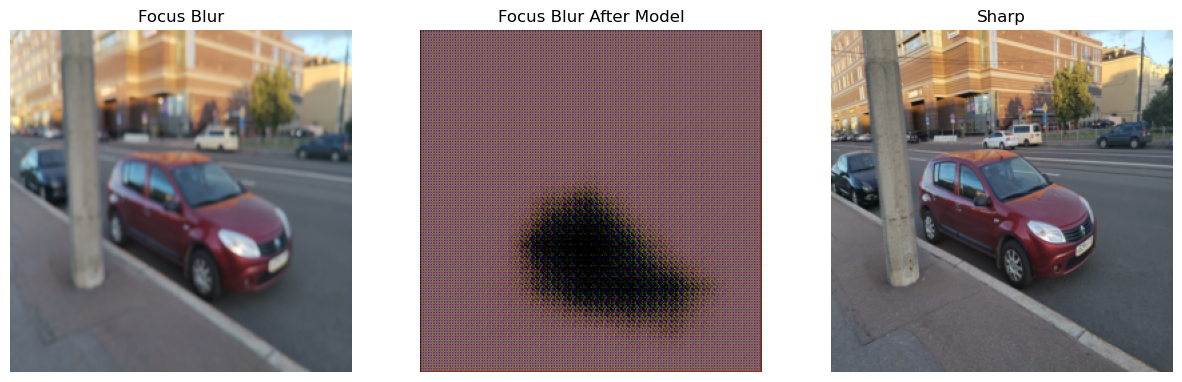

100%|██████████| 22/22 [00:31<00:00,  1.41s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/100], Loss: 0.05386369675397873


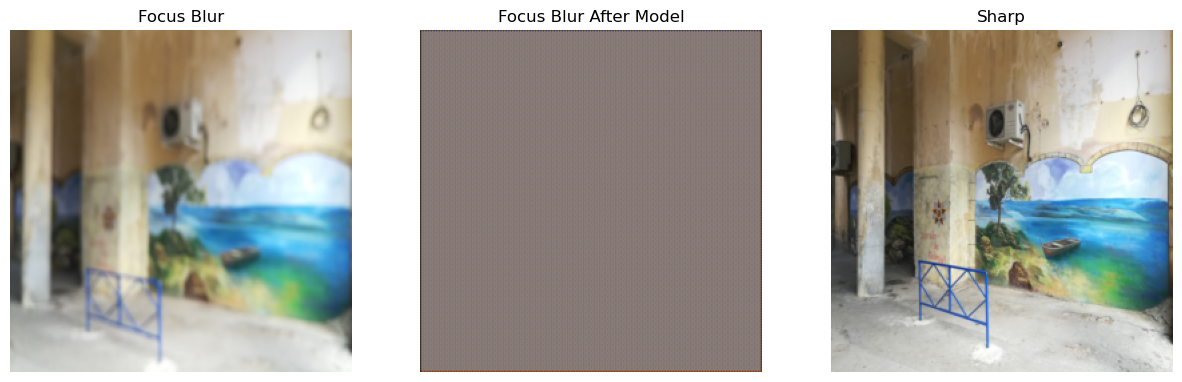

100%|██████████| 22/22 [00:31<00:00,  1.44s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/100], Loss: 0.06501150131225586


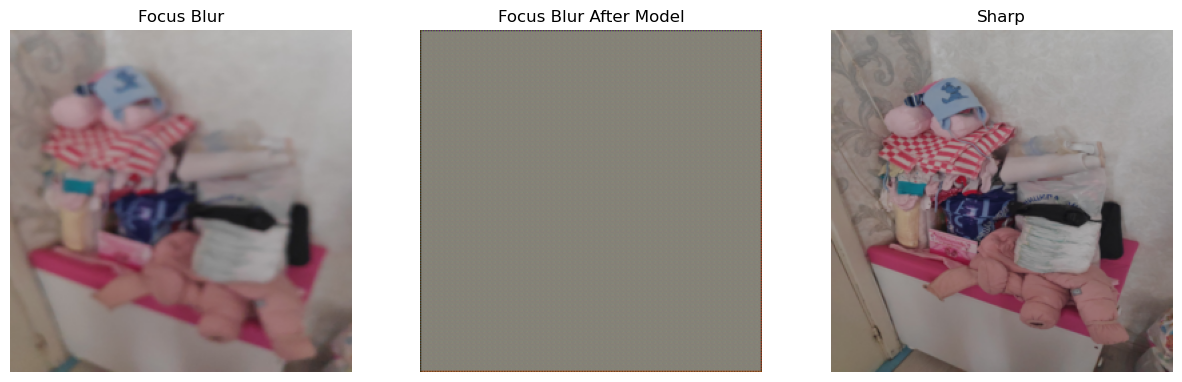

100%|██████████| 22/22 [00:31<00:00,  1.44s/it]


Epoch [4/100], Loss: 0.08598081767559052


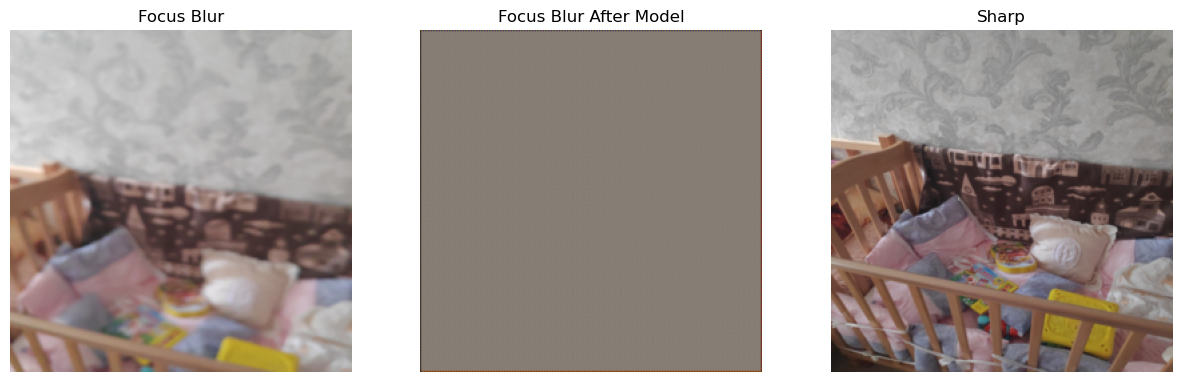

100%|██████████| 22/22 [00:31<00:00,  1.43s/it]


Epoch [5/100], Loss: 0.049072299152612686


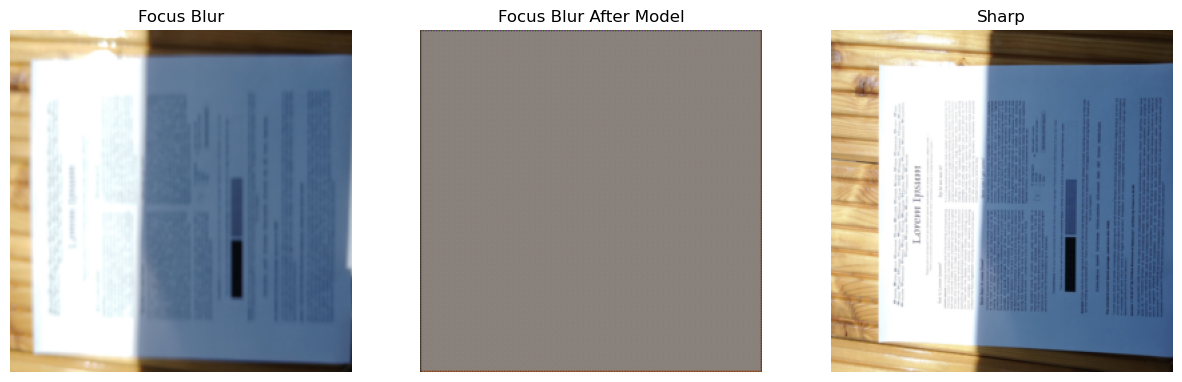

 14%|█▎        | 3/22 [00:05<00:37,  1.96s/it]


KeyboardInterrupt: 

In [ ]:
deblurrer.train()